# What is ARIMA?  
## Auto-Regressive Integrated Moving Average  
is a general class of statistical models for time series analysis forecasting  
ARIMA uses the historical data to predict the future.  

__ASSUMPTION__:  
the time series has its statistical properties remain constant across time. So it is **data without a trend** and with a constant mean value. (normal temperature)

__three components__:  
AR(p) + I(d) + MA(q)  

> **Variations**  
> AR: (p,0,0)  
> MA: (0,0,q)  
> ARMA: (p,0,q)  
> - (Auto-Regressive): _time series is linearly regressed on its own past values_  
> - (Integrated): _time series can be differenced to become stationary if its not (compute the difference between consecutive observations)_  
> - (Moving Average): _time series is regressed on the past forecast errors (past values predict future values)_

## Step 0: Explore the dataset

## Get data

In [14]:
import pandas as pd
import yfinance as yahoo_finance
# get data
get_data = yahoo_finance.Ticker("SIE.DE")
data = get_data.history(period="5y")
# transform data into pandas df
df = pd.DataFrame(data)

## Calculate the mean of open and closed value

In [15]:
df.drop(df.iloc[:,5: 6],axis=1, inplace=True)
df['Mean'] = df[['Open', 'Low']].mean(axis=1)
df = df.loc[:,['Mean']]
df

,Mean
Date,
2019-12-19 00:00:00+01:00,90.423024
2019-12-20 00:00:00+01:00,90.950736
2019-12-23 00:00:00+01:00,91.214582
2019-12-27 00:00:00+01:00,91.090405
2019-12-30 00:00:00+01:00,90.818808
...,...
2024-12-13 00:00:00+01:00,192.029999
2024-12-16 00:00:00+01:00,190.630005
2024-12-17 00:00:00+01:00,189.619995


## Explore the data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1276 entries, 2019-12-19 00:00:00+01:00 to 2024-12-19 00:00:00+01:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mean    1276 non-null   float64
dtypes: float64(1)
memory usage: 19.9 KB


<Axes: xlabel='Date'>

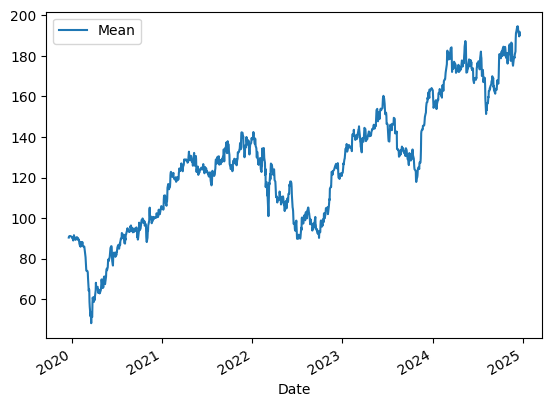

In [16]:
import matplotlib.pyplot as plt
df.info()
df.plot()

<Axes: xlabel='Date'>

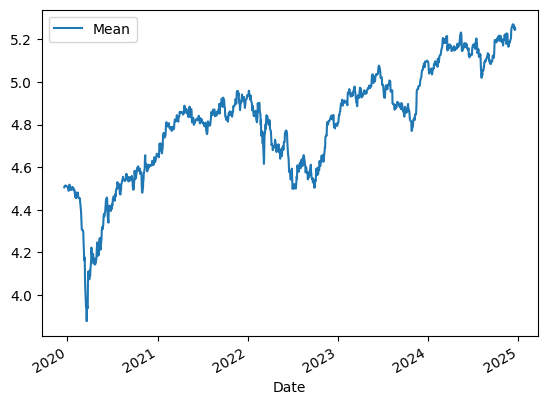

In [17]:
import numpy as np 
df = np.log(df) # don't forget to transform the data back when making real prediction

df.plot()

## Split the data into train and test

In [18]:
# from sklearn.model_selection import train_test_split
# X = df.index
# Y = df['Mean']
# x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# x_test

print(len(df))
print(int(len(df)*0.8))

df_train = df[:411].copy()
df_test = df[411:].copy()


1276
1020


## Step 1: Check for stationary time series

## Method #1: time series plot
from the previous plot we can see the time series has an up trend 

## Method #2: ACF plot and PACF plot

__ACF__: autocorrelation function.  
is the correlation of the time series with its lags, e.g., yt and yt-k for k 1,2,3...  
Time stamp a is correlated with time stamp b and b is correlated with c. So you have two correlations between data points:  
a -> c  
a -> b -> c

__PACF__: partial autocorrelation function.  
is the partial correlation of the time series with its lags, after removing the effects of the lower-order-lags between them.  
If b is compared pretty low we need just the **direct correlation**:  
a -> c

Video: https://www.kaggle.com/code/iamleonie/time-series-interpreting-acf-and-pacf :)

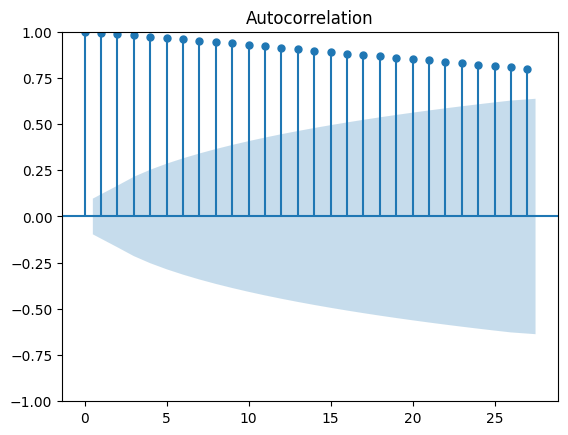

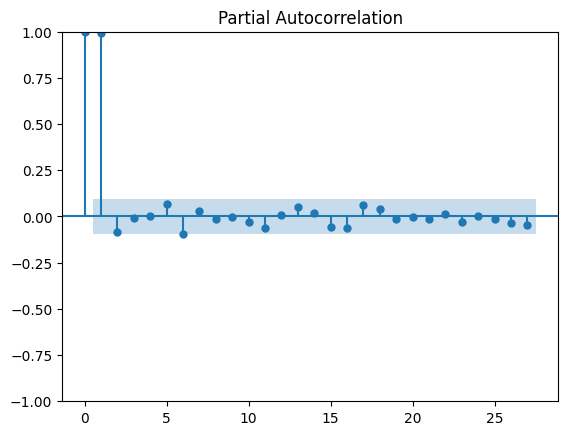

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(df_train)

pacf_original = plot_pacf(df_train)

## Method #3: ADF test  
augemented Dickey-Fuller test  
null hypothesis: there is a unit root (non-stationary)  

The hypothesis pair is as follows:
$$ H_0: \rho = 1 $$ 
  This means the autoregressive (AR) component has a unit root, and the variable is therefore non-stationary.

$$ H_1: -1 < \rho < 1 $$
  This implies there is no stochastic non-stationarity; however, deterministic non-stationarity may exist. In such cases, the time series is referred to as *trend-stationary*.


In [20]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_train)
print(f'p-value: {adf_test[1]}')

p-value: 0.8475387646945367


## Transform to stationary: differencing

<Axes: xlabel='Date'>

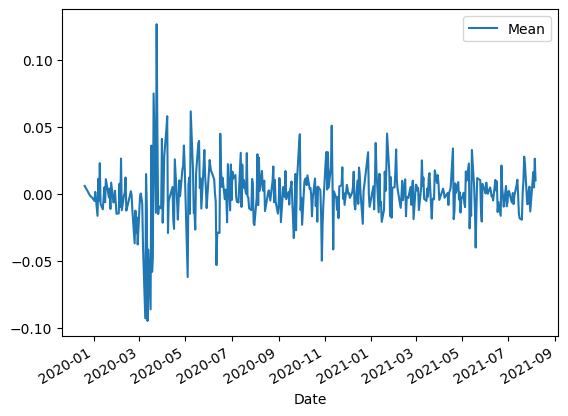

In [21]:
df_train_diff = df_train.diff().dropna()
df_train_diff.plot()

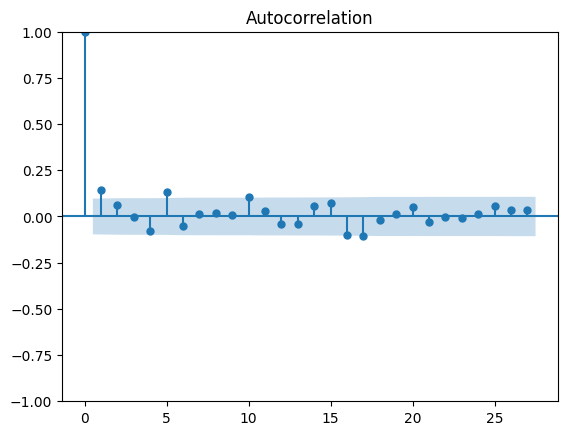

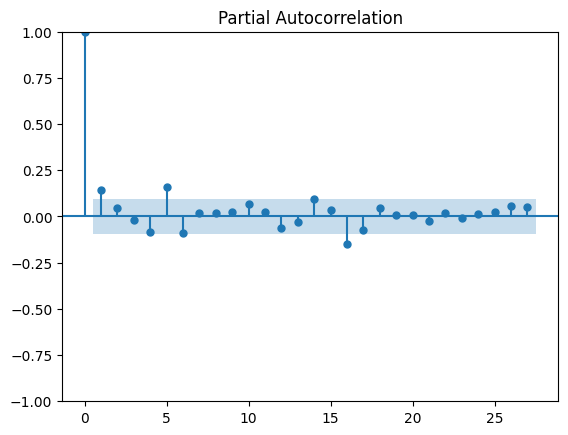

In [22]:
acf_original = plot_acf(df_train_diff)

pacf_original = plot_pacf(df_train_diff)

In [23]:
adf_test_diff = adfuller(df_train_diff)
print(f'p-value: {adf_test_diff[1]}')

p-value: 5.198063982806088e-12


## Step 2: Determine ARIMA models parameters p,q

## Step 3: Fit the ARIMA model

In [24]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_train, order = (2,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   Mean   No. Observations:                  411
Model:                 ARIMA(2, 1, 0)   Log Likelihood                1025.411
Date:                Thu, 19 Dec 2024   AIC                          -2044.822
Time:                        20:15:20   BIC                          -2032.773
Sample:                             0   HQIC                         -2040.055
                                - 411                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1365      0.034      4.012      0.000       0.070       0.203
ar.L2          0.0471      0.027      1.724      0.085      -0.006       0.101
sigma2         0.0004   1.42e-05     27.694      0.0

/Users/andy/anaconda3/envs/env_arima/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/andy/anaconda3/envs/env_arima/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/andy/anaconda3/envs/env_arima/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## Step 4: Make time series predictions

## Residuals
WIP
## Density  
**Definition**  
A density plot is a representation of the distribution of a numeric variable. It uses a kernel density estimate to show the probability density funtion of the variable. (Its a smooth version of the histogram and is used in the same concept.)

**What for**  
Density plots are used to study the distribution of one or a few variables. Checking the distribution of your variables one by one is probably the first task you should do when you get a new dataset. It delivers a good quantity of information. 

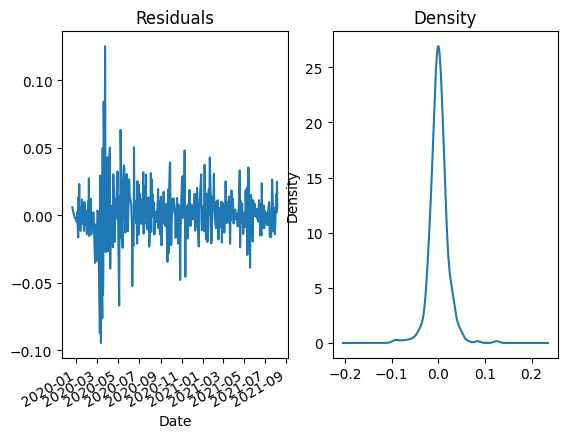

In [26]:
import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(title="Density", kind="kde", ax=ax[1])
plt.show()


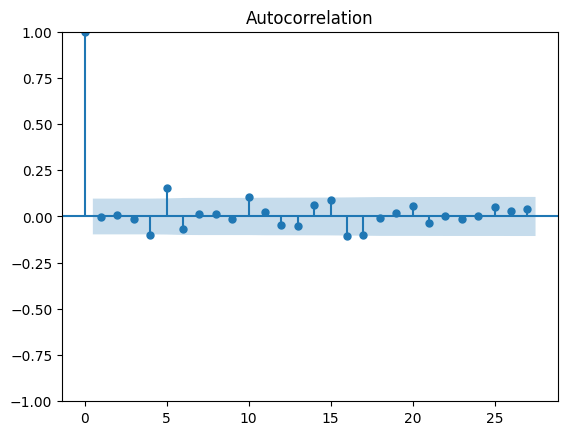

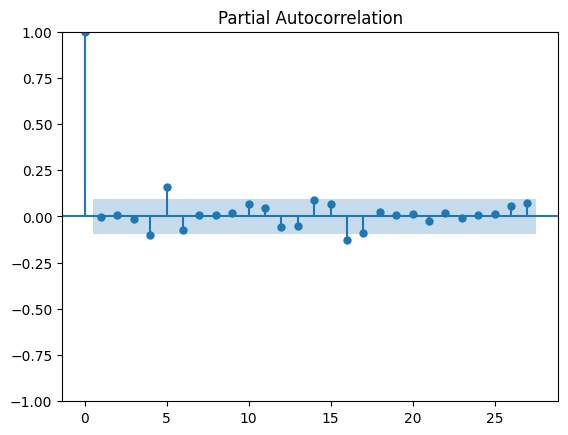

In [27]:
acf_res = plot_acf(residuals)
pacf_res = plot_pacf(residuals)